In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('home-data/train.csv', index_col='Id')
X_test_full = pd.read_csv('home-data/test.csv', index_col='Id')


In [2]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X_full.shape

(1460, 80)

In [4]:
##check for null values

X_full.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [5]:
X_full.isnull().sum()[X_full.isnull().sum()!=0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

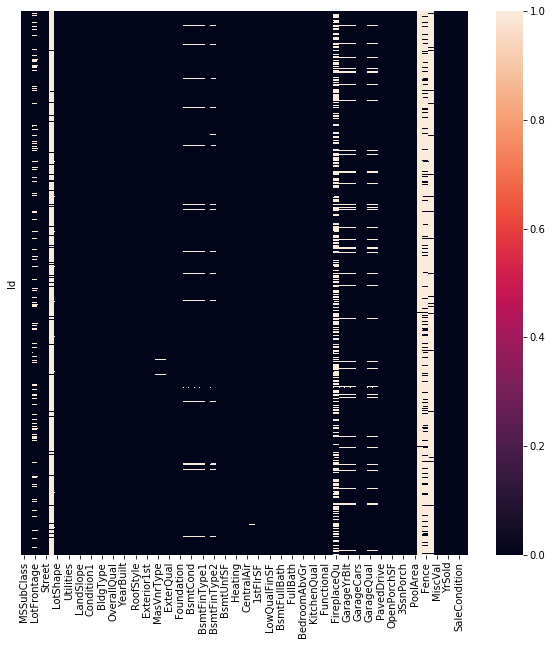

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(X_full.isnull(),yticklabels=False,cbar=True)

In [7]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()
X_final=X_full[my_cols].copy()
y_final=y.copy()


In [8]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


In [9]:
#import necessary libraries

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [10]:
from xgboost import XGBRegressor
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
                              ('imputer',SimpleImputer(strategy='constant')),
                              ('onehot',OneHotEncoder(handle_unknown='ignore'))
]) 

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# model definition
model = XGBRegressor()

In [11]:
#Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

#hyperparamter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

params = {
 'model__max_depth': [2,6,10],
 'model__n_estimators' : [400,800,1000],
 'model__learning_rate': [0.1, 0.05]
}

grid_search = GridSearchCV(estimator=my_pipeline,
                           param_grid=params,                          
                           n_jobs=10,
                           cv=10,
                           verbose=True)

In [12]:
# Preprocessing of training data, fit model 
grid_search.fit(X_train,y_train)

# Preprocessing of validation data, get predictions
preds = grid_search.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.8min
/home/ashu96.ar/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed: 27.8min finished


MAE: 17707.142899186645


In [17]:
#Save test predictions to output file

preds_test = grid_search.predict(X_test)
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('output_XGBoost.csv', index=False)